<a href="https://colab.research.google.com/github/heet25itachi/TIMEPASS_BUDDY/blob/main/Forecasting_Crude_Oil_Price_Volatility_by_Heston_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:96: SyntaxWarning: invalid escape sequence '\s'
<>:98: SyntaxWarning: invalid escape sequence '\s'
<>:99: SyntaxWarning: invalid escape sequence '\s'
<>:96: SyntaxWarning: invalid escape sequence '\s'
<>:98: SyntaxWarning: invalid escape sequence '\s'
<>:99: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2058101149.py:96: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_title('Heston Model Simulation - Volatility Paths ($\sqrt{v_t}$)', fontsize=14)
/tmp/ipython-input-2058101149.py:98: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_ylabel('Volatility ($\sigma_t$)', fontsize=12)
/tmp/ipython-input-2058101149.py:99: SyntaxWarning: invalid escape sequence '\s'
  ax2.axhline(np.sqrt(theta), color='red', linestyle='--', alpha=0.6, label='Long-term Mean Volatility ($\sqrt{\\theta}$)')


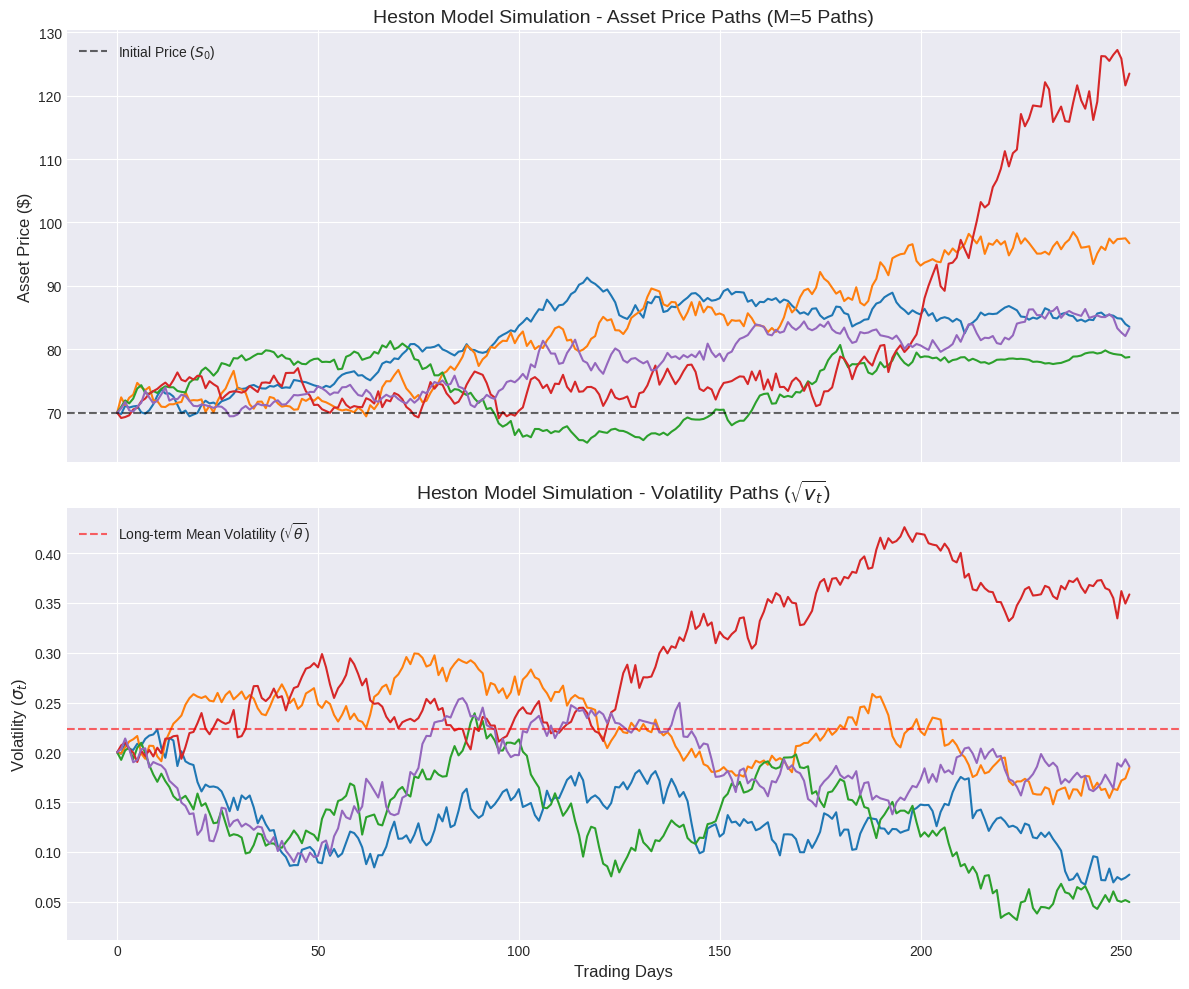

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def heston_model_simulation(S0, v0, kappa, theta, sigma, rho, r, T, N, M):
    """
    Simulates the Heston Model (Stochastic Volatility) using the Euler-Maruyama scheme.

    The model consists of two SDEs:
    1. dS_t = r * S_t * dt + sqrt(v_t) * S_t * dW_1,t
    2. dv_t = kappa * (theta - v_t) * dt + sigma * sqrt(v_t) * dW_2,t

    Args:
        S0 (float): Initial asset price (e.g., Crude Oil price).
        v0 (float): Initial variance (volatility squared).
        kappa (float): Rate of mean reversion for variance.
        theta (float): Long-term mean variance.
        sigma (float): Volatility of volatility (vol-vol).
        rho (float): Correlation between price and volatility processes.
        r (float): Risk-free rate.
        T (float): Total time horizon (e.g., 1.0 for 1 year).
        N (int): Number of time steps.
        M (int): Number of simulation paths (for the asset price).

    Returns:
        tuple: (Time array, Asset Price Paths, Volatility Paths)
    """

    # Ensure v0 is positive for the simulation
    v0 = max(v0, 0)
    dt = T / N  # Time step size
    time = np.linspace(0, T, N + 1)

    # Initialize arrays for price and volatility paths
    S = np.zeros((N + 1, M))
    v = np.zeros((N + 1, M))

    S[0, :] = S0
    v[0, :] = v0

    # Generate correlated random variables for the entire simulation
    # dW_1,t and dW_2,t are coupled via rho
    Z1 = np.random.standard_normal((N, M))
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.standard_normal((N, M))

    # Euler-Maruyama Discretization
    for i in range(N):
        # Enforce Feller condition (2 * kappa * theta > sigma**2) for stability
        # The Feller condition prevents the volatility from becoming negative.
        # Although not strictly required for Euler, it ensures realistic behavior.

        # Volatility SDE (CIR Process)
        dv = kappa * (theta - v[i, :]) * dt + sigma * np.sqrt(np.maximum(v[i, :], 0)) * np.sqrt(dt) * Z2[i, :]
        v[i+1, :] = v[i, :] + dv

        # Volatility cannot be negative in the next step
        v[i+1, :] = np.maximum(v[i+1, :], 0)

        # Asset Price SDE (Stochastic Volatility GBM)
        dS = r * S[i, :] * dt + np.sqrt(np.maximum(v[i, :], 0)) * S[i, :] * np.sqrt(dt) * Z1[i, :]
        S[i+1, :] = S[i, :] + dS

    return time, S, v

# --- Model Parameters (Example for a Commodity like Crude Oil) ---
S0 = 70.0    # Initial Price ($70 per barrel)
v0 = 0.04    # Initial Variance (volatility of 20%)
kappa = 2.0  # Mean reversion rate (relatively fast)
theta = 0.05 # Long-term variance (volatility of 22.3%)
sigma = 0.3  # Volatility of volatility (vol-vol)
rho = 0.1    # Correlation (slightly positive for commodities)
r = 0.03     # Risk-free rate

# --- Simulation Parameters ---
T = 1.0      # Simulate over 1 year
N = 252      # 252 trading days (steps)
M = 5        # Number of simulation paths

# Run the simulation
time, S_paths, v_paths = heston_model_simulation(S0, v0, kappa, theta, sigma, rho, r, T, N, M)

# --- Plotting the Results ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Asset Price Paths
ax1.plot(time * 252, S_paths)
ax1.set_title(f'Heston Model Simulation - Asset Price Paths (M={M} Paths)', fontsize=14)
ax1.set_ylabel('Asset Price ($)', fontsize=12)
ax1.axhline(S0, color='black', linestyle='--', alpha=0.6, label='Initial Price ($S_0$)')
ax1.legend(loc='upper left')

# Plot 2: Volatility Paths
# Convert variance v_t to standard deviation (volatility) sqrt(v_t)
volatility_paths = np.sqrt(v_paths)
ax2.plot(time * 252, volatility_paths)
ax2.set_title('Heston Model Simulation - Volatility Paths ($\sqrt{v_t}$)', fontsize=14)
ax2.set_xlabel('Trading Days', fontsize=12)
ax2.set_ylabel('Volatility ($\sigma_t$)', fontsize=12)
ax2.axhline(np.sqrt(theta), color='red', linestyle='--', alpha=0.6, label='Long-term Mean Volatility ($\sqrt{\\theta}$)')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()
